<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Fakhredin Abdi
### Student Number : 99106458
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data , batch_size = 10000)

In [6]:
print(valid_loader)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [7]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

def res_block(in_num):
    layers = [nn.Conv2d(in_channels = in_num, out_channels = in_num , kernel_size=3, padding=1), 
              nn.ReLU(),
              nn.Conv2d(in_channels = in_num, out_channels = in_num , kernel_size=3, padding=1), 
              nn.ReLU()]
    return nn.Sequential(*layers)


class ResidualClassifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.seq1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.res1 = res_block(16)
      self.seq2 = nn.Sequential(
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU()
      )

      self.res2 = res_block(64)

      self.seq3 = nn.Sequential(
          nn.AdaptiveAvgPool2d(output_size=(1, 1)),
          nn.Flatten(),
          nn.Linear(in_features=64, out_features=10)
      )
      
        

    def forward(self, x):
        out1 = self.seq1(x)
        out2 = self.res1(out1) + out1
        out3 = self.seq2(out2)
        out4 = self.res2(out3) + out3
        out5 = self.seq3(out4)
        return out5

# Train Model (30 Points)

In [8]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr = 0.001)
 

In [9]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 8
train_loss_list = []
validation_loss_list = []
train_acc_list = []
validation_acc_list = []


for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    model.train(True)
    all_preds = []
    all_labels = []
    for images, labels in train_loader:
        all_labels += labels
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs , labels)
        loss.backward()
        optimizer.step()

        all_preds += torch.argmax(outputs, 1)
        train_loss += loss
    correct_preds = 0
    for i in range(len(all_preds)):
      if all_labels[i] == all_preds[i]:
        correct_preds += 1
    number_of_batch = 50000 // 16
    train_acc = correct_preds/(50000)
    train_loss /= number_of_batch

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            valid_all_labels = labels
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            valid_pred = torch.argmax(outputs, 1)
            loss = criterion(outputs, labels)
            correct_pred_count = 0
            for i in range(len(valid_all_labels)):
              if valid_pred[i] == valid_all_labels[i]:
                correct_pred_count += 1
            val_acc += correct_pred_count / 10000
            val_loss += loss
    
    print("Epoch ", epoch + 1)
    print("Training: Loss = {}, Acc = {}".format(train_loss , train_acc))
    print("Validation: Loss = {}, Acc = {}".format(val_loss , val_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    validation_loss_list.append(val_loss)
    validation_acc_list.append(val_acc)


Epoch  1
Training: Loss = 0.28721678256988525, Acc = 0.9051
Validation: Loss = 0.09856784343719482, Acc = 0.9705
Epoch  2
Training: Loss = 0.08100205659866333, Acc = 0.97522
Validation: Loss = 0.05062480643391609, Acc = 0.9842
Epoch  3
Training: Loss = 0.054105550050735474, Acc = 0.98388
Validation: Loss = 0.04995337128639221, Acc = 0.9852
Epoch  4
Training: Loss = 0.04110652208328247, Acc = 0.98742
Validation: Loss = 0.06637421995401382, Acc = 0.9796
Epoch  5
Training: Loss = 0.03386658802628517, Acc = 0.98982
Validation: Loss = 0.04213479533791542, Acc = 0.988
Epoch  6
Training: Loss = 0.027424318715929985, Acc = 0.99138
Validation: Loss = 0.039599545300006866, Acc = 0.9893
Epoch  7
Training: Loss = 0.02297203242778778, Acc = 0.9926
Validation: Loss = 0.04278172180056572, Acc = 0.9876
Epoch  8
Training: Loss = 0.01968349702656269, Acc = 0.99348
Validation: Loss = 0.028281686827540398, Acc = 0.9915


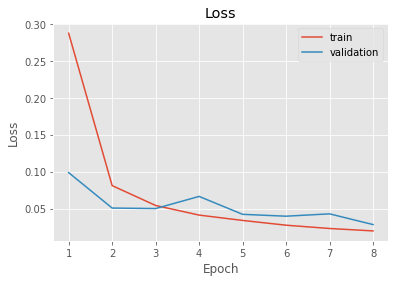

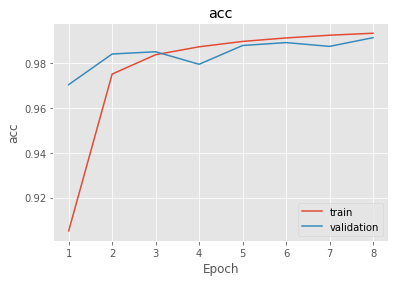

In [10]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
# train_loss_list = train_loss_list.to('cpu')
# train_acc_list = train_acc_list.to('cpu')
# validation_loss_list = validation_loss_list.to('cpu')
# validation_acc_list = validation_acc_list.to('cpu')

for i in range(len(train_loss_list)):
  train_loss_list[i] = train_loss_list[i].item()
for i in range(len(validation_loss_list)):
  validation_loss_list[i] = validation_loss_list[i].item()
plt.plot([i+1 for i in range(len(train_loss_list))], train_loss_list, label='train')
plt.plot([i+1 for i in range(len(train_loss_list))], validation_loss_list, label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()


plt.plot([i+1 for i in range(len(train_acc_list))], train_acc_list, label='train')
plt.plot([i+1 for i in range(len(train_acc_list))], validation_acc_list, label='validation')
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.title("acc")
plt.legend()

# Test Model (20 Points)

In [11]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

all_labels = []
predictions = []
with torch.no_grad():
      for images, labels in test_loader:
        for num in labels:
          all_labels.append(int(num))

        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        for num in preds:
          predictions.append(int(num))


10000


accuracy for test is : 0.9923


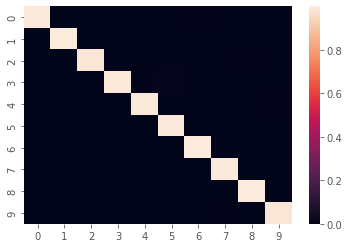

In [12]:
counter = 0
for i in range(len(predictions)):
  if predictions[i] == all_labels[i]:
    counter += 1
print("accuracy for test is : {}".format(counter/10000))
temp = confusion_matrix(predictions,all_labels , normalize='true')
sb.heatmap(pd.DataFrame(temp))
